In today's post, we will take a break from deep learning and turn our attention to the topic of rejection sampling. We've discussed the topic of sampling some times on this blog before, such as [Gibbs sampling](https://jaketae.github.io/study/gibbs-sampling/) and [Markov Chain Monte Carlo methods](https://jaketae.github.io/study/MCMC/). I thought it'd be nice to revisit some old relevant topics in statistics and sampling as a quick break. Let's take a look at how rejection sampling works, and why you might consider using it.

# Concept

Rejection sampling, similar to MCMC or Gibbs sampling, is usually employed when we want to sample from some distribution. As you might expect, such distributions are normally intractable or too complicated to directly sample from; therefore, we use rejection sampling as a meas of approximating the sampling process. 

## Context

Let's say we have some function $p(x)$, which is too complicated to sample from. Sometimes, this distribution might not even be properly normalized, namely

$$
f(x) = \frac{p(x)}{\int_{- \infty}^\infty p(x) \, dx} = \frac{p(x)}{C} \tag{1}
$$

where $f(x)$ is the normalized distribution; $p(x)$, the distribution we are given, and $C$, the normalizing constant. Under circumstances in which $p$ is too convoluted, it could be too time-consuming to evaluate the integral to find the normalizing constant. 

This is precisely when rejection sampling comes in handy. To get started with rejection sampling, we need to decide on some simpler distribution $q(x)$ that will serve as a proposal distribution. The proposal distribution should also satisfy the requirement that its domain matches that of the target distribution. This is because we will be sampling from the proposal distribution to simulate the process of directly sampling from $p$. If the domains do not match, this premise obviously does not stand. 

## Decision Rule

Let's say that we have sampled some sample $s$ from the proposal distribution $q$. How do we proceed from here?

Naturally, we need to consider some rule with which to decide whether this sample should be taken or not. The intuition is that we would like to take this sample if it is highly likely under the target distribution $p$, and reject it if otherwise. On the other hand, we also want to consider whether this sample is a likely to occur again under the proposal distribution $q$. Therefore, we can consider a total of four cases:

1. $s$ is likely to occur in both $p$ and $q$
2. $s$ is likely to occur in $p$, but not $q$
3. $s$ is likely to occur in $q$, but not $p$
4. $s$ is unlikely to occur in both $p$ and $q$

I think the interesting cases are (2) and (3). In (2), the sample is likely to occur under the target distribution, but not much so under the proposal distribution. In this case, we would want to accept the sample, since we never know when $s$ will be sampled again from the target distribution. Conversely, in (3), we want to reject it with a high probability since we will be seeing a lot of that same sample from the proposal distribution, but not from the target distribution. 

With this intuition in mind, we might have a better of idea why the decision rule for rejection sampling is the way it is. The rule might be expressed as follows:

$$
\mathbb{I}_{\in \{0, 1 \}} = \frac{p(s)}{K q(s)} > u \tag{2}
$$

where

$$
u \sim U(0, 1)
$$

If the indicator variable, denoted as $\mathbb{I}$ is 1 (or true), then we accept the sample; else, we reject it. 

This was my hasty attempt at formalizing, admittedly with some abuse and misuse of notation, so let's clarify what the decision rule is in plain words. First, $K$ is just a constant we use to scale up the proposal distribution such that 

$$
K q(s) \geq p(s)  \forall s \in S \tag{3}
$$

Since we don't know if the target distribution $p$ has properly been scaled or not, we have to scale the proposal distribution accordingly so that $q$ is always greater or equal to $p$ across the common domain. This makes a little more sense if you think about (2). This appropriate scaling will ensure that the fraction always lies between zero and one, which is what we want: we're essentially comparing the value of this fraction with a uniform random variable sampled from the range $[0, 1]$. If the value of the fraction is larger than this randomly sampled uniform variable, then we accept the sample $s$; if not, we reject it and move onto the next sampling iteration. 

Note the fractional expression essentially encompassing the intuition we developed earlier. If the denominator is small and the numerator is large, that means the sample falls under case (2); the reverse of that would be (3). The larger the value of the fraction, the more likely we are to accept it, which is the desired behavior. 

Now that we've gained a basic understanding of how rejection sampling works, let's get into the code implementation. 

# Implementation

Implementing rejection sampling is actually very simple if we use the right tools. Let's begin by importing the modules we will need for this tutorial. 

In [25]:
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format="retina"

## Setup

First, we need a dummy target distribution which we want to sample from. Let's use a simple Gaussian mixture model for the job. 

In [2]:
def p(x):
    return norm.pdf(x, loc=30, scale=10) + norm.pdf(x, loc=80, scale=20)

Note that this Gaussian mixture is obviously not normalized appropriately. This is totally fine, and rejection sampling can handle the case for us.

Next, let's use a simple univariate Gaussian distribution as our target distribution. It is easy to check that the target and proposal distributions share the same domain.

In [3]:
def q(x):
    return norm.pdf(x, loc=50, scale=30)

Let's visualize the two distributions. 

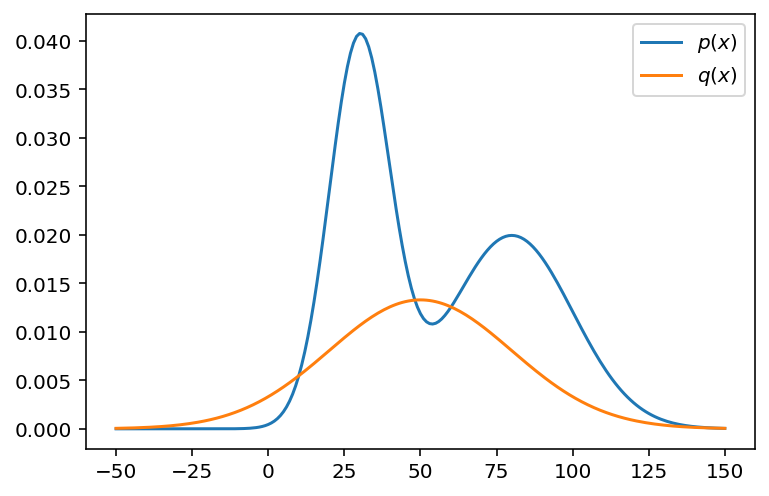

In [14]:
x = np.arange(-50, 151)
fig, ax = plt.subplots()
ax.plot(x, p(x), label=r"$p(x)$")
ax.plot(x, q(x), label=r"$q(x)$")
plt.legend()
plt.show()

Following the decision rule outlined in (2), we need to scale the proposal distribution $q$ to ensure that the fractional value will always be bounded between zero and one. To find the scaling constant, we can simply look at how large the PDF of the target distribution has to get in order to envelop the target distribution. 

In [15]:
k = max(p(x) / q(x))

In this case, we only consider the domain from -50 to 150, so perhaps this scaling value is not exactly precise, but it should be good enough for our purposes. 

Let's attempt another visualization to quickly verify that our scaled proposal distribution always lies above the proposal distribution.

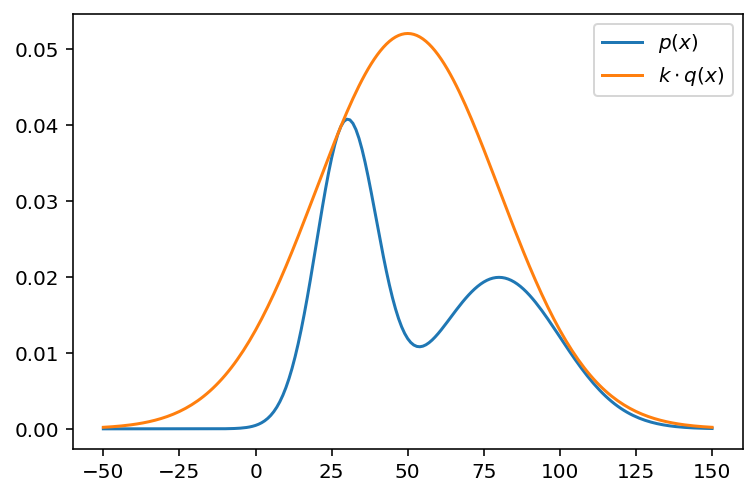

In [17]:
fig, ax = plt.subplots()
ax.plot(x, p(x), label=r"$p(x)$")
ax.plot(x, k * q(x), label=r"$k \cdot q(x)$")
plt.legend()
plt.show()

Great! Now, it's time to write out the rejection sampling algorithm. 

## Vectorization

We could use a naïve iteration method to sample one sample, decide to accept or reject that sample, and repeat this process for a set number of iterations. This would take the form of some for or while loop. 

However, every computer scientist knows that loops are slow. Instead, we want to make use of NumPy's vectorization capabilities. This means that we can sample a whole bunch of numbers at once, compute the threshold decision value in parallel, and decide whether or accept or reject each sample, all at once in one scoop. Below is one way we could approach this simulation using vectorization:

In [21]:
def sample(size):
    xs = np.random.normal(50, 30, size=size)
    cs = np.random.uniform(0, 1, size=size)
    mask = p(xs) / (k * q(xs)) > cs
    return xs[mask]        

First, we sample some numbers from the proposal distribution. The `xs` corresponds to these candidate samples. Then, we sample the same number of random variables from the uniform distribution. We then calculate the activation values and compare them with the sampled uniform random threshold values. If the activation is larger than the threshold, we accept the sample at that index. We then return only those samples that satisfy this condition. 

Let's see if this function can be used to reasonably approximate the target distribution.

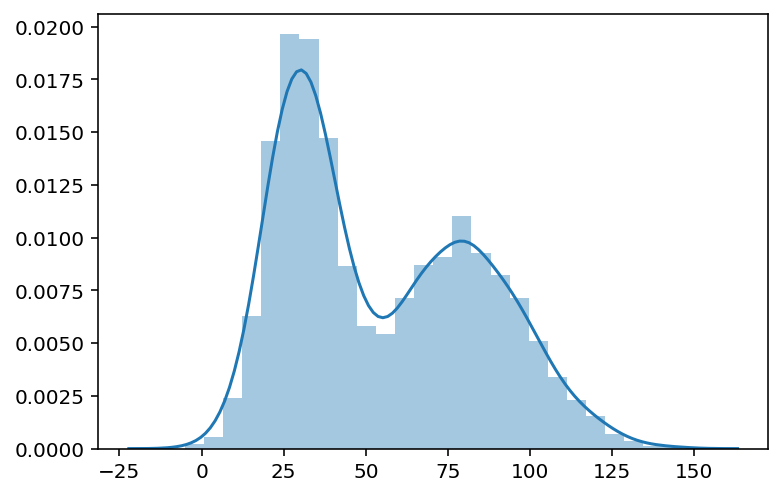

In [28]:
samples = sample(10000)
sns.distplot(samples)
plt.show()

It seems like our simulation worked! After 10000 iterations, we obtain a reasonably accurate approximation of the target distribution. In other words, no matter how complicated the underlying target distribution, we can mimic sampling from that distribution by using a tractable proposal distribution that spans across the same domain. 

# Conclusion

In this short post, we took a brief look at rejection sampling: when it is used, why it works, and how one can go about implementing it. While we've dealt with a rather contrived example in this post, it is not difficult to see how this algorithm could easily be applied in other real-life contexts when faced with intractable distributions. 

More personally, this post was a good opportunity for me to revisit and remind myself of some of the older posts I've written back then, such as MCMC or Gibbs sampling. Sampling is used in all aspects of statistical programming. Having a basic understanding of how such methods work can provide useful intuition. It's also interesting to think and learn about in the first place. 

I hope you've enjoyed reading this post. Catch you up in the next one!